# Study normalizations of attr/rep

In [23]:
from pathlib import Path

from gnn_tracking.models.graph_construction import MLGraphConstructionFromChkpt
from gnn_tracking.metrics.losses.metric_learning import GraphConstructionHingeEmbeddingLoss
from gnn_tracking.utils.loading import TrackingDataModule
from gnn_tracking.training.ml import MLModule
from tqdm import tqdm
from gnn_tracking.utils.dictionaries import to_floats

In [2]:
from pathlib import Path
lightning_home = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/model_exchange/gc")
assert lightning_home.is_dir()
chkpt_name = "quiet-origami-prawn_compatible.ckpt"
ml_chkpt_path= lightning_home / chkpt_name
assert ml_chkpt_path.is_file()

In [3]:
ml_module =  MLModule.load_from_checkpoint(
    ml_chkpt_path,
)

[15:58:27] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[15:58:27] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses.metric_learning
[15:58:27] DEBUG: Getting class GraphConstructionKNNScanner from module gnn_tracking.graph_construction.k_scanner


In [4]:
dm = TrackingDataModule(
    identifier="point_clouds_v8",
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/"
        ],
        sample_size=1000,
        # If you run into memory issues, reduce this
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/"
        ],
        stop=5
    ),
)

In [5]:
dm.setup("fit")
data = dm.datasets["train"][0]

[15:58:29] INFO: DataLoader will load 900 graphs (out of 900 available).
[15:58:29] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21999_s0.pt
[15:58:29] INFO: DataLoader will load 5 graphs (out of 1000 available).
[15:58:29] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29004_s0.pt


In [47]:
import torch
from pytorch_lightning.core.mixins import HyperparametersMixin
from torch import Tensor as T
from torch.linalg import norm
from torch_cluster import radius_graph

from gnn_tracking.metrics.losses import MultiLossFct, MultiLossFctReturn
from gnn_tracking.utils.graph_masks import get_good_node_mask_tensors

def _hinge_loss_components(
    *,
    x: T,
    att_edges: T,
    rep_edges: T,
    r_emb_hinge: float,
    p_attr: float,
    p_rep: float,
) -> tuple[T, T]:
    eps = 1e-9

    dists_att = norm(x[att_edges[0]] - x[att_edges[1]], dim=-1)
    norm_att = att_edges.shape[1] + eps
    v_att = torch.sum(torch.pow(dists_att, p_attr)) / norm_att

    dists_rep = norm(x[rep_edges[0]] - x[rep_edges[1]], dim=-1)
    norm_rep = rep_edges.shape[1] + eps
    v_rep = r_emb_hinge - torch.sum(torch.pow(dists_rep, p_rep)) / norm_rep

    return v_att, v_rep


class GraphConstructionHingeEmbeddingLoss(MultiLossFct, HyperparametersMixin):
    # noinspection PyUnusedLocal
    def __init__(
        self,
        *,
        lw_repulsive: float = 1.0,
        r_emb: float = 1.0,
        max_num_neighbors: int = 256,
        pt_thld: float = 0.9,
        max_eta: float = 4.0,
        p_attr: float = 1.0,
        p_rep: float = 1.0,
    ):
        """Loss for graph construction using metric learning.

        Args:
            lw_repulsive: Loss weight for repulsive part of potential loss
            r_emb: Radius for edge construction
            max_num_neighbors: Maximum number of neighbors in radius graph building.
                See https://github.com/rusty1s/pytorch_cluster#radius-graph
            pt_thld: pt threshold for particles of interest
            max_eta: maximum eta for particles of interest
            p_attr: Power for the attraction term (default 1: linear loss)
            p_rep: Power for the repulsion term (default 1: linear loss)
        """
        super().__init__()
        self.save_hyperparameters()

    def _get_edges(
        self, *, x: T, batch: T, true_edge_index: T, mask: T, particle_id: T
    ) -> tuple[T, T]:
        """Returns edge index for graph"""
        near_edges = radius_graph(
            x,
            r=self.hparams.r_emb,
            batch=batch,
            loop=False,
            max_num_neighbors=self.hparams.max_num_neighbors,
        )
        # Every edge has to start at a particle of interest, so no special
        # case with noise
        rep_edges = near_edges[:, mask[near_edges[0]]]
        rep_edges = rep_edges[:, particle_id[rep_edges[0]] != particle_id[rep_edges[1]]]
        att_edges = true_edge_index[:, mask[true_edge_index[0]]]
        return att_edges, rep_edges

    # noinspection PyUnusedLocal
    def forward(
        self,
        *,
        x: T,
        particle_id: T,
        batch: T,
        true_edge_index: T,
        pt: T,
        eta: T,
        reconstructable: T,
        **kwargs,
    ) -> MultiLossFctReturn:
        mask = get_good_node_mask_tensors(
            pt=pt,
            particle_id=particle_id,
            reconstructable=reconstructable,
            eta=eta,
            pt_thld=self.hparams.pt_thld,
            max_eta=self.hparams.max_eta,
        )
        att_edges, rep_edges = self._get_edges(
            x=x,
            batch=batch,
            true_edge_index=true_edge_index,
            mask=mask,
            particle_id=particle_id,
        )
        attr, rep = _hinge_loss_components(
            x=x,
            att_edges=att_edges,
            rep_edges=rep_edges,
            r_emb_hinge=self.hparams.r_emb,
            p_attr=self.hparams.p_attr,
            p_rep=self.hparams.p_rep,
        )
        losses = {
            "attractive": attr,
            "repulsive": rep,
        }
        weights: dict[str, float] = {
            "attractive": 1.0,
            "repulsive": self.hparams.lw_repulsive,
        }
        return MultiLossFctReturn(
            loss_dct=losses,
            weight_dct=weights,
            extra_metrics={
                "n_rep_edges": rep_edges.shape[1],
                "n_att_edges": att_edges.shape[1],
            }
        )

In [48]:
loss = GraphConstructionHingeEmbeddingLoss()

In [114]:
losses = []
for i, data in enumerate(dm.train_dataloader()):
    data = data.to("cuda")
    out = loss(
        x=ml_module(data.to("cuda"))["H"],
        particle_id=data.particle_id,
        batch=data.batch,
        true_edge_index=data.edge_index,
        pt=data.pt,
        eta=data.eta,
        reconstructable=data.reconstructable,
    )
    mask = get_good_node_mask_tensors(
        pt=data.pt,
        particle_id=data.particle_id,
        reconstructable=data.reconstructable,
        eta=data.eta,
    )
    out_dct = to_floats(out.loss_dct) | to_floats(out.extra_metrics)
    out_dct["n_hits"] = data.num_nodes
    out_dct["n_hits_oi"] = mask.sum().item()
    losses.append(out_dct)
    if i > 500:
        break

In [115]:
import pandas as pd
df = pd.DataFrame.from_records(losses)

In [116]:
df["att_to_rep_edges"] = df["n_att_edges"] / df["n_rep_edges"]
df["att_to_rep"] = df["attractive"] / df["repulsive"]
df["rep_edges_per_hit_oi"] = df["n_rep_edges"] / df["n_hits_oi"]
df["alt_rep"] = df["repulsive"] * df["rep_edges_per_hit_oi"]
# attractive norm
df["rep_an"] = df["repulsive"] * df["n_rep_edges"] / df["n_att_edges"]

In [126]:
def rel_std(series):
    return series.std() / series.mean()


array([[<Axes: title={'center': 'att_to_rep_edges'}>]], dtype=object)

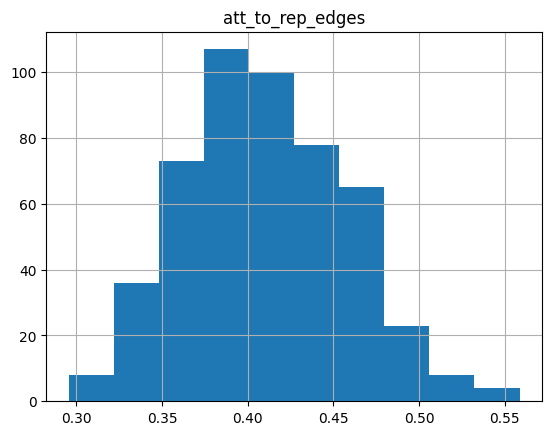

In [117]:
df.hist("att_to_rep_edges")

array([[<Axes: title={'center': 'attractive'}>]], dtype=object)

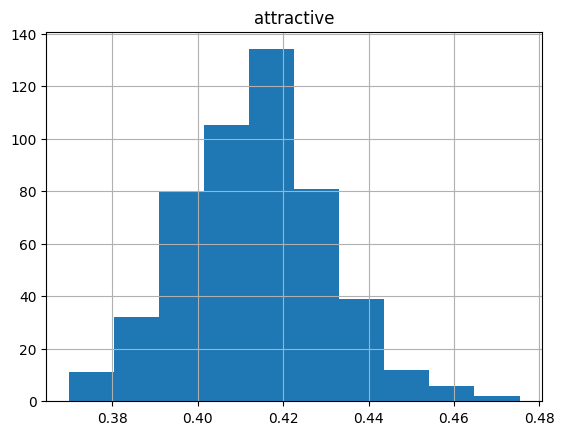

In [118]:
df.hist("attractive")

0.018139718755031217

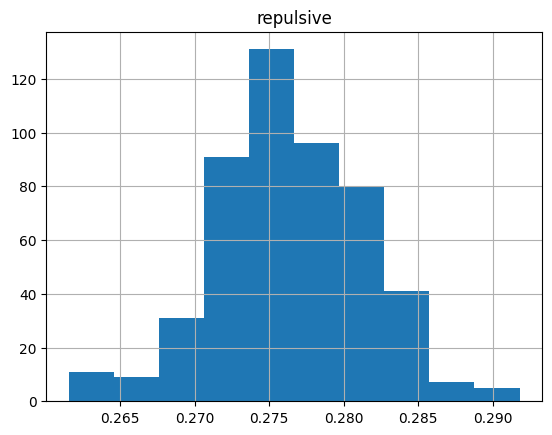

In [127]:
df.hist("repulsive")
rel_std(df["repulsive"])

0.04676672710031747

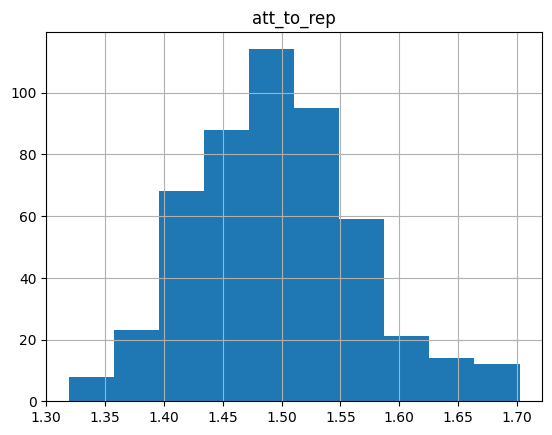

In [128]:
df.hist("att_to_rep")
rel_std(df["att_to_rep"])

(<Axes: >, 0.11808735324426732)

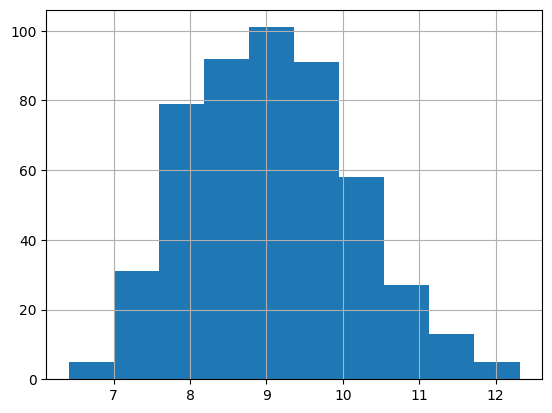

In [129]:
df["rep_edges_per_hit_oi"].hist(), rel_std(df["rep_edges_per_hit_oi"])

<Axes: xlabel='n_hits_oi', ylabel='n_rep_edges'>

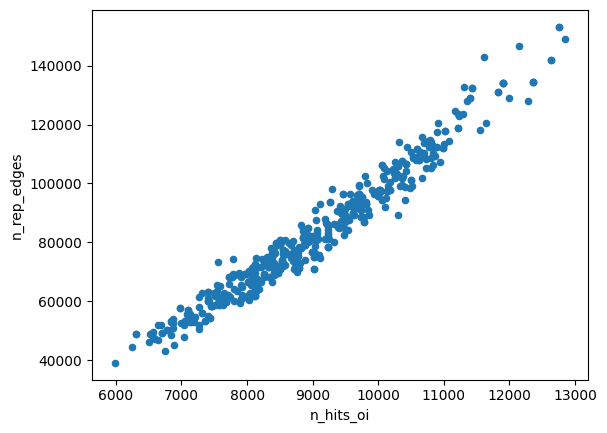

In [135]:
df.plot.scatter("n_hits_oi", "n_rep_edges")

0.020438899524230784

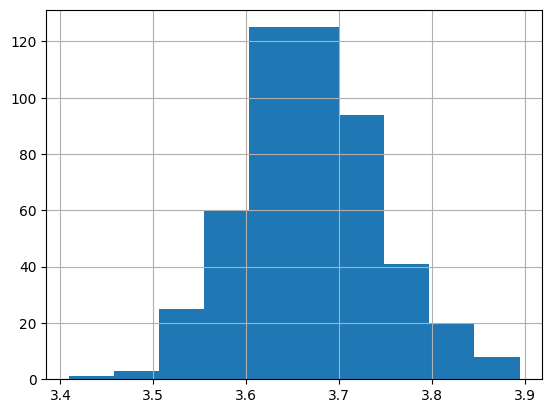

In [137]:
(df["n_att_edges"] / df["n_hits_oi"]).hist()
rel_std(df["n_att_edges"] / df["n_hits_oi"])

<Axes: xlabel='n_hits_oi', ylabel='n_att_edges'>

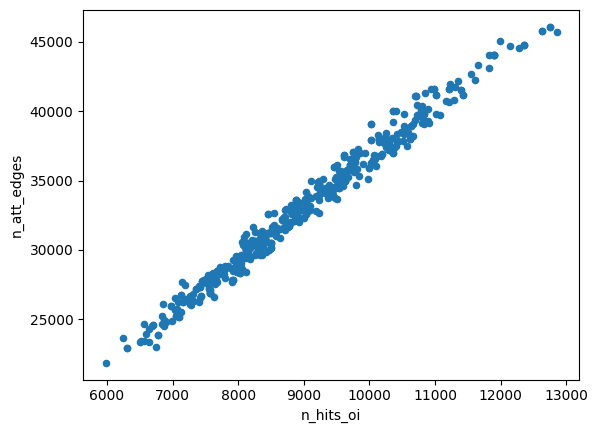

In [136]:
df.plot.scatter("n_hits_oi", "n_att_edges")

0.12198444131110271

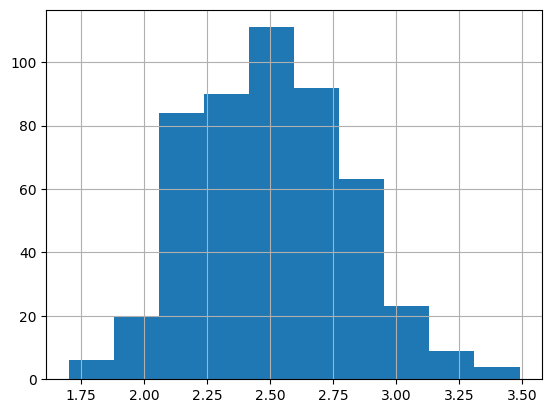

In [130]:
df["alt_rep"].hist()
rel_std(df["alt_rep"])

0.13254721042912604

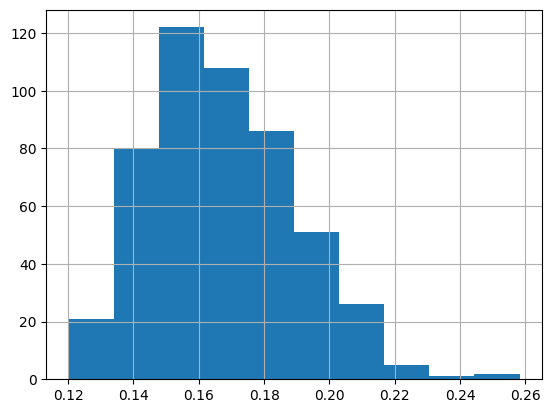

In [131]:
(df["attractive"] / df["alt_rep"]).hist()
rel_std(df["attractive"] / df["alt_rep"])

0.1270961679020078

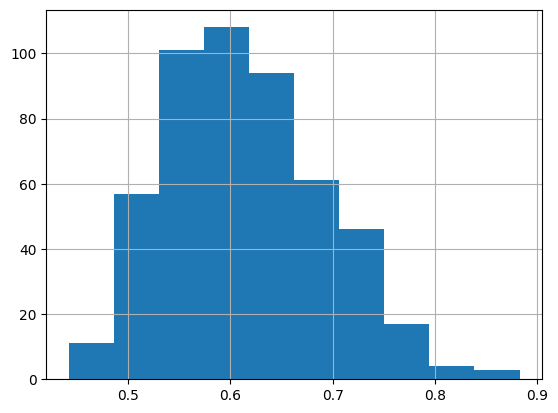

In [132]:
(df["attractive"] / df["rep_an"]).hist()
rel_std(df["attractive"] / df["rep_an"])